In [38]:
from pathlib import Path
from omnibelt import toposort, load_json, save_json
from itertools import product, combinations
# import pyperclip
import random
import json
from PIL import Image
from graphviz import Digraph
import matplotlib.pyplot as plt
import io
# import clipboard
import networkx as nx
from tqdm.notebook import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from omniply import tool, ToolKit, Context

import numpy as np
import torch
from causalbenchmark.novo.simulation.models import Bernoulli, ConditionalBernoulli, BernoulliNetwork
from causalbenchmark.novo.seeding import NewsHeadlines, StatisticsPrompting, Story
# from causalbenchmark.novo.seeding.prompting import GraphInfo
from causalbenchmark.novo.templating import FixedTemplate, SimpleTemplater, FileTemplate
from causalbenchmark.novo import misc

In [2]:
spark_generator = NewsHeadlines(locs=['gb', 'de', 'fr', 'it', 'nl'], 
                                dataset_root=Path(r'/home/fleeb/workspace/local_data/nnn/babel-briefings-v1'),
                                # dataset_root=Path(r'C:\Users\anwan\workspace\local_data\nnn\babel-briefings-v1'),
                                ).load(pbar=tqdm)
len(spark_generator.article_IDs)

  0%|          | 0/5 [00:00<?, ?it/s]

In [41]:
# ctx = Story(story_root=misc.data_root() / 'stories', story_id='test17')
ctx = Story(story_root=misc.data_root() / 'stories').populate_defaults()
ctx.include(spark_generator,)
# print(ctx)
# ctx['seed'] = 6660483#2494534#91220#1684065#6805333
# ctx['seed'] = 3357669#6660483
# ctx['spark'] = '''Title: Naples, Apple renews the Academy program with the Federico II University - Rai News
# Description: The academic training born between Cupertino and the University in 2016 restarts at the San Giovanni a Teduccio headquarters
# Original Language: Italian'''
print(ctx['seed'])
print(ctx['spark'])

280411
Title: Deutz: Engine manufacturer is cutting hundreds of jobs in Germany - t-online.de
Description: The auto industry is suffering greatly from the corona pandemic. The traditional engine manufacturer Deutz also feels this. The company wants to cut many jobs in Germany. Around 1,000 jobs are expected to be eliminated worldwide by 2022.
Original Language: German


In [42]:
# if 'prompt_story' in ctx:
#     del ctx['prompt_motivation']
print(ctx['prompt_motivation'])

We have a news article headline, and we would like to identify a potential specific analysis that could be motivated by the article. Importantly, we would like specific details to be mentioned in the setting, even if they don't show up in the original article, to paint a vivid picture of the motivation and potential features of the data.

Here is the article headline:

```
Title: Deutz: Engine manufacturer is cutting hundreds of jobs in Germany - t-online.de
Description: The auto industry is suffering greatly from the corona pandemic. The traditional engine manufacturer Deutz also feels this. The company wants to cut many jobs in Germany. Around 1,000 jobs are expected to be eliminated worldwide by 2022.
Original Language: German
```

Write a 2-3 sentence introduction to a statistical analysis that could be motivated by this article. Be sure to include specific details about the data that would be used and the analysis that would be performed. You do not need to write the entire analys

In [45]:
##############################################
motivation_raw = '''

{
  "title": "Impact_of_Covid_on_Auto_Industry_Job_Market",
  "introduction": "This analysis explores the ripple effects of the COVID-19 pandemic on the auto industry's job market, inspired by Deutz's recent job cuts. By comparing employment data from before and during the pandemic, specifically focusing on auto manufacturers in Germany, we can uncover trends and assess the broader impact on jobs. Our look into various companies' workforce sizes, hiring and layoff rates will reveal the pandemic's real impact on this sector."
}


'''
##############################################
ctx['motivation'] = json.loads(motivation_raw)

In [46]:
# if 'prompt_graph' in ctx:
#     del ctx['prompt_graph']
# print(FileTemplate('graph').fill_in(ctx))
print(ctx['prompt_graph'])

We are interested in building a causal model based on the explicit and implicit assumptions contained in the specified article and then using causal inference to evaluate the reasoning. Answer the following questions to design an interesting, simple, and most importantly realistic causal model from a news article.

To help understand the instructions here are some tips:
- all variables are always binary and (at least in principle) measurable, so when creating and selecting variables, make sure it is reasonable to treat them as binary
- whenever you propose a variable, make sure to define the meaning of each value it can take, and mention whether it is observable or not
- outcome variables are always observable, and should always have 2-3 causal parents (including treatment, mediator, and confounder variables)
- treatment variables are always observable and intervenable, that means it must be possible to (at least in principle) change their value if desired, and these should generally h

In [49]:
# nodes = ctx['nodes']
#################################################
nodes_raw = '''


[
  {
    "name": "Job Loss in Auto Industry",
    "description": "Reduction in the number of jobs in the auto industry",
    "type": "outcome",
    "observed": true,
    "values": ["No job loss", "Job loss"],
    "parents": ["Company Financial Stability", "Public Demand for Cars", "COVID-19 Pandemic Impact"]
  },
  {
    "name": "COVID-19 Pandemic Impact",
    "description": "Impact of the COVID-19 pandemic on the economy",
    "type": "treatment",
    "observed": true,
    "values": ["No impact", "Impact"],
    "parents": ["Global Economic Health"]
  },
  {
    "name": "Government Economic Policy",
    "description": "Government policies affecting the economy during the pandemic",
    "type": "treatment",
    "observed": true,
    "values": ["No policy change", "Policy change"],
    "parents": ["Global Economic Health"]
  },
  {
    "name": "Global Economic Health",
    "description": "Overall health of the global economy",
    "type": "confounder",
    "observed": true,
    "values": ["Poor economic health", "Good economic health"],
    "parents": []
  },
  {
    "name": "Auto Industry Health",
    "description": "Financial health and stability of the auto industry",
    "type": "confounder",
    "observed": true,
    "values": ["Unstable", "Stable"],
    "parents": []
  },
  {
    "name": "Company Financial Stability",
    "description": "Financial stability of individual companies in the auto industry",
    "type": "mediator",
    "observed": true,
    "values": ["Unstable", "Stable"],
    "parents": ["COVID-19 Pandemic Impact", "Government Economic Policy", "Auto Industry Health"]
  },
  {
    "name": "Public Demand for Cars",
    "description": "Consumer demand for automobiles",
    "type": "mediator",
    "observed": true,
    "values": ["Low demand", "High demand"],
    "parents": ["Auto Industry Health"]
  },
  {
    "name": "Media Coverage of Job Losses",
    "description": "Extent of media coverage on job losses in the auto industry",
    "type": "collider",
    "observed": true,
    "values": ["Limited coverage", "Extensive coverage"],
    "parents": ["COVID-19 Pandemic Impact", "Job Loss in Auto Industry"]
  }
]



'''
#################################################
if len(nodes_raw):
    nodes = json.loads(nodes_raw)
varparents = {node['name']: node['parents'] for node in nodes}
varorder = toposort(varparents)
nodes = sorted(nodes, key=lambda x: varorder.index(x['name']))
nodes = [node for node in nodes if len(node['parents']) or any(node['name'] in parent for parent in varparents.values())]
ctx['nodes'] = nodes

ValueError: Could not save to JPEG for display

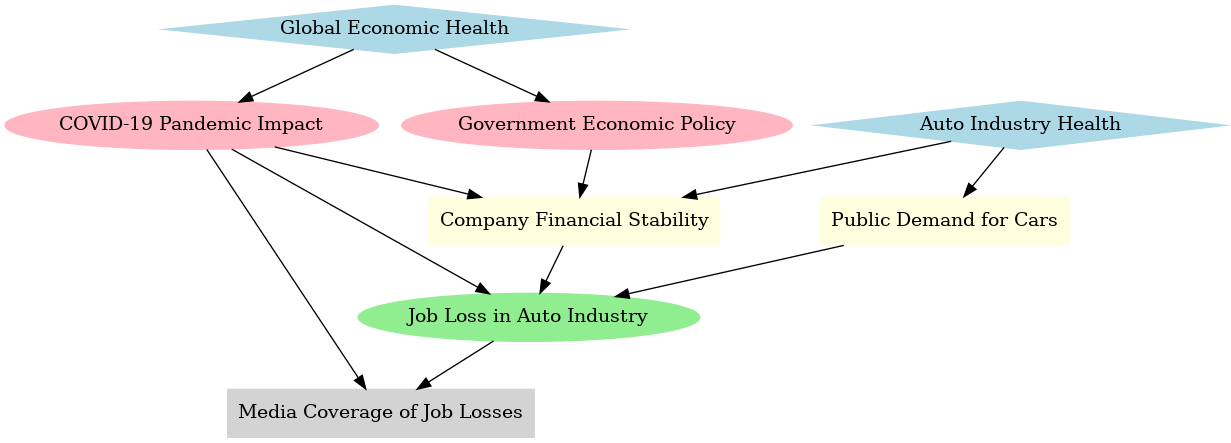

In [50]:
dot = Digraph(comment='Causal Model')
node_styles = {
    "treatment": {"shape": "ellipse", "style": "filled", "color": "lightpink"},
    "outcome": {"shape": "ellipse", "style": "filled", "color": "lightgreen"},
    "confounder": {"shape": "diamond", "style": "filled", "color": "lightblue"},
    "mediator": {"shape": "box", "style": "filled", "color": "lightyellow"},
    "collider": {"shape": "box", "style": "filled", "color": "lightgray"}
}
for node in ctx['nodes']:
    style = node_styles.get(node["type"], {"shape": "ellipse"})
    dot.node(node["name"], node["name"], **style)
for node in ctx['nodes']:
    for parent in node["parents"]:
        dot.edge(parent, node["name"])
# dot.view()
dot.render(str(misc.temp_root() / 'graph'), format='png')
Image.open(misc.temp_root() / 'graph.png')

In [52]:
# if 'prompt_story' in ctx:
#     del ctx['prompt_motivation']
print(FileTemplate('structure').fill_in(ctx))
# print(ctx['prompt_structure'])


We have a causal bayes net model for an analysis about this topic:

This analysis explores the ripple effects of the COVID-19 pandemic on the auto industry's job market, inspired by Deutz's recent job cuts. By comparing employment data from before and during the pandemic, specifically focusing on auto manufacturers in Germany, we can uncover trends and assess the broader impact on jobs. Our look into various companies' workforce sizes, hiring and layoff rates will reveal the pandemic's real impact on this sector.

Write a list of 4-8 concise and well-worded sentences that describe the structure and associated assumptions of the causal graph. The sentences should be ordered from describing the most noteworthy/surprising features of the graph to the most natural/intuitive features. Use an intuitive conversational style to describe the causal graph, and avoid using technical terms or jargon, but you can describe the variables and their relationships (including using terms like "affects",

In [53]:
#################################################

structure_raw = '''
[
    {"sentence": "The overall health of the global economy plays a pivotal role, influencing not only the pandemic's economic impact but also shaping government policies during these challenging times.", "involved": ["Global Economic Health", "COVID-19 Pandemic Impact", "Government Economic Policy"]},
    {"sentence": "Interestingly, the financial health and stability of the auto industry, a critical sector, is affected by broader economic factors and in turn, influences consumer demand for cars.", "involved": ["Auto Industry Health", "Public Demand for Cars"]},
    {"sentence": "The pandemic's impact and government responses directly sway the financial stability of auto companies, which is a key factor leading to job reductions in the industry.", "involved": ["COVID-19 Pandemic Impact", "Government Economic Policy", "Company Financial Stability", "Job Loss in Auto Industry"]},
    {"sentence": "Consumer demand for automobiles, tied closely to the industry's health, also plays a significant role in determining job stability within these companies.", "involved": ["Public Demand for Cars", "Job Loss in Auto Industry"]},
    {"sentence": "Job losses in the auto industry, a consequence of multiple economic factors, surprisingly become a focal point of media attention, alongside the direct effects of the pandemic.", "involved": ["Job Loss in Auto Industry", "Media Coverage of Job Losses", "COVID-19 Pandemic Impact"]},
    {"sentence": "This analysis paints a comprehensive picture, linking the ripple effects of a global pandemic to individual job security and public perception, as reflected in media coverage.", "involved": ["COVID-19 Pandemic Impact", "Job Loss in Auto Industry", "Media Coverage of Job Losses"]}
]


'''

#################################################
ctx['structure'] = json.loads(structure_raw)

In [54]:
# if 'prompt_stats' in ctx:
#     del ctx['descriptions']
#     del ctx['prob_questions']
#     del ctx['prompt_stats']
# print(FileTemplate('stats').fill_in(ctx))
print(ctx['prompt_stats'])

We have a causal bayes net based on the following topic:

This analysis explores the ripple effects of the COVID-19 pandemic on the auto industry's job market, inspired by Deutz's recent job cuts. By comparing employment data from before and during the pandemic, specifically focusing on auto manufacturers in Germany, we can uncover trends and assess the broader impact on jobs. Our look into various companies' workforce sizes, hiring and layoff rates will reveal the pandemic's real impact on this sector.

Now we would like to estimate the probabilities of certain events in a corresponding causal bayes net.

Using commonsense, estimate the probabilities of the following events:

1. what is the probability that "Global Economic Health" is "Good economic health" (rather than "Poor economic health")?
2. when "Global Economic Health" is "Poor economic health": what is the probability that "COVID-19 Pandemic Impact" is "Impact" (rather than "No impact")?
3. when "Global Economic Health" is "G

In [55]:
# probabilities = ctx['stats']
#################################################

probabilities_raw = '''

{
  "1": [0.4, 0.6],
  "2": [0.7, 0.9],
  "3": [0.5, 0.7],
  "4": [0.6, 0.8],
  "5": [0.3, 0.5],
  "6": [0.5, 0.7],
  "7": [0.2, 0.4],
  "8": [0.6, 0.8],
  "9": [0.3, 0.5],
  "10": [0.7, 0.9],
  "11": [0.1, 0.3],
  "12": [0.4, 0.6],
  "13": [0.2, 0.4],
  "14": [0.5, 0.7],
  "15": [0.2, 0.4],
  "16": [0.6, 0.8],
  "17": [0.7, 0.9],
  "18": [0.8, 0.95],
  "19": [0.5, 0.7],
  "20": [0.6, 0.8],
  "21": [0.3, 0.5],
  "22": [0.4, 0.6],
  "23": [0.2, 0.4],
  "24": [0.3, 0.5],
  "25": [0.2, 0.4],
  "26": [0.4, 0.6],
  "27": [0.6, 0.8],
  "28": [0.7, 0.9]
}





'''

#################################################
ctx['stats'] = json.loads(probabilities_raw)

In [56]:
raw_prob_samples = []
def to_prob_range(raw):
    raw = [prange for _, prange in sorted(raw.items(), key=lambda item: int(item[0]))]
    return torch.tensor(raw)

prob_ranges = to_prob_range(ctx['stats'])
lower_bound, upper_bound = prob_ranges.t()

variables = {}
for node in ctx['nodes']:
    if len(node['parents']):
        variables[node['name']] = ConditionalBernoulli([variables[parent] for parent in node['parents']])
    else:
        variables[node['name']] = Bernoulli(0.5)
net = BernoulliNetwork(variables)
def mc_samples(N, *fns):
    estimates = []
    for _ in tqdm(range(N)):
        param_sample = torch.rand(len(prob_ranges), 1) * (upper_bound - lower_bound) + lower_bound
        net.set_params(param_sample)
        estimates.append([fn() for fn in fns])
    return torch.tensor(estimates)
def make_ate_fn(treatment, outcome, conditions=None):
    def ate_fn():
        return net.ate(treatment, conditions=conditions)[outcome].item()
    return ate_fn
def make_corr_fn(v1, v2):
    def corr_fn():
        return net.correlation(v1, v2).item()
    return corr_fn
treatment1, treatment2 = [n for n in ctx['treatments']]
# t1vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment1][0]
# t2vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment2][0]
outcome = ctx['outcome']#['name']
# ovals = [node['values'] for node in ctx['nodes'] if node['name'] == outcome][0]
confounders = [node for node in ctx['confounders']]

print(tabulate([
    [treatment1['name'], *treatment1['values'], treatment1['description']],
    [treatment2['name'], *treatment2['values'], treatment2['description']],
    [outcome['name'], *outcome['values'], outcome['description']],
]))

cate_keys = [(treatment, confounder, cval) for treatment in ctx['treatments'] for confounder in ctx['confounders'] for cval in [0, 1]]
cate_fns = [make_ate_fn(treatment['name'], outcome['name'], conditions={confounder['name']: val}) for treatment, confounder, val in cate_keys]
ate1, ate2, corr1, corr2, *cates = mc_samples(50, make_ate_fn(treatment1['name'], outcome['name']), make_ate_fn(treatment2['name'], outcome['name']),
                                      make_corr_fn(treatment1['name'], outcome['name']), make_corr_fn(treatment2['name'], outcome['name']), *cate_fns).t()

print('\n'.join(f'{node["name"]!r} means {node["description"]}' for node in ctx['nodes']))
print(tabulate([
    [f'{treatment1["values"][1]}', f'{treatment1["name"]}', f'{outcome["values"][1]}', f'{outcome["name"]}', ate1.mean(), corr1.mean(), ],
    [f'{treatment2["values"][1]}', f'{treatment2["name"]}', f'{outcome["values"][1]}', f'{outcome["name"]}', ate2.mean(), corr2.mean(), ],
], headers=['Treatment Value', 'Treatment', 'Outcome Value', 'Outcome', 'ATE', 'Correlation']))

--------------------------  ----------------  -------------  -------------------------------------------------------------
COVID-19 Pandemic Impact    No impact         Impact         Impact of the COVID-19 pandemic on the economy
Government Economic Policy  No policy change  Policy change  Government policies affecting the economy during the pandemic
Job Loss in Auto Industry   No job loss       Job loss       Reduction in the number of jobs in the auto industry
--------------------------  ----------------  -------------  -------------------------------------------------------------


  0%|          | 0/50 [00:00<?, ?it/s]

/home/fleeb/miniconda3/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


'Global Economic Health' means Overall health of the global economy
'COVID-19 Pandemic Impact' means Impact of the COVID-19 pandemic on the economy
'Government Economic Policy' means Government policies affecting the economy during the pandemic
'Auto Industry Health' means Financial health and stability of the auto industry
'Company Financial Stability' means Financial stability of individual companies in the auto industry
'Public Demand for Cars' means Consumer demand for automobiles
'Job Loss in Auto Industry' means Reduction in the number of jobs in the auto industry
'Media Coverage of Job Losses' means Extent of media coverage on job losses in the auto industry
Treatment Value    Treatment                   Outcome Value    Outcome                           ATE    Correlation
-----------------  --------------------------  ---------------  -------------------------  ----------  -------------
Impact             COVID-19 Pandemic Impact    Job loss         Job Loss in Auto Industry   

/home/fleeb/miniconda3/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


Treatment                                          ATE    Correlation  Outcome
-----------------------------------------------  -----  -------------  -----------------------------------------------
Good economic health Global Economic Health      -0.2           -0.41  Impact COVID-19 Pandemic Impact
Good economic health Global Economic Health      -0.3           -0.33  Policy change Government Economic Policy
Good economic health Global Economic Health       0              0     Stable Auto Industry Health
Good economic health Global Economic Health       0             -0.08  Stable Company Financial Stability
Good economic health Global Economic Health       0              0     High demand Public Demand for Cars
Good economic health Global Economic Health      -0.02          -0.01  Job loss Job Loss in Auto Industry
Good economic health Global Economic Health      -0.07          -0.1   Extensive coverage Media Coverage of Job Losses
Impact COVID-19 Pandemic Impact                   0

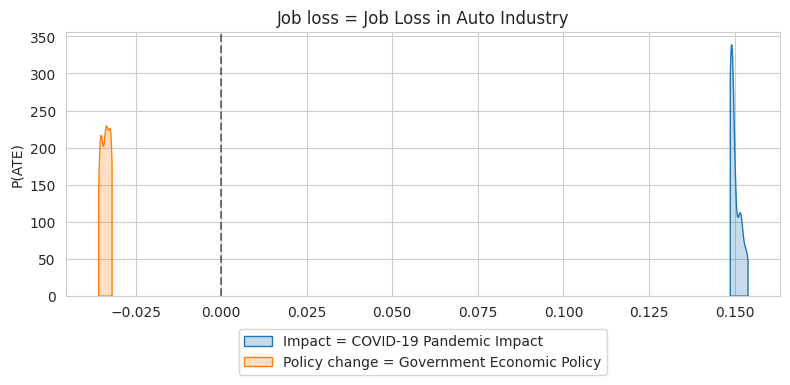

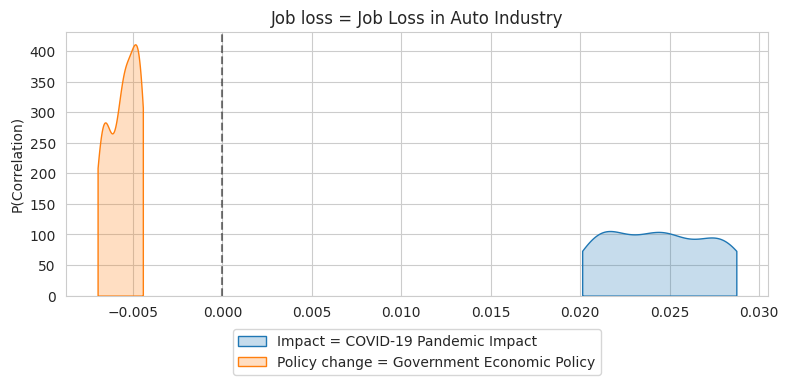

In [57]:
plt.figure(figsize=(8, 4))
sns.kdeplot(ate1, label=f'{treatment1["values"][1]} = {treatment1["name"]}', fill=True, clip=(min(ate1), max(ate1)));
sns.kdeplot(ate2, label=f'{treatment2["values"][1]} = {treatment2["name"]}', fill=True, clip=(min(ate2), max(ate2)));
plt.title(f'{outcome["values"][1]} = {outcome["name"]}')
plt.ylabel(f'P(ATE)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

plt.figure(figsize=(8, 4))
sns.kdeplot(corr1, label=f'{treatment1["values"][1]} = {treatment1["name"]}', fill=True, clip=(min(corr1), max(corr1)));
sns.kdeplot(corr2, label=f'{treatment2["values"][1]} = {treatment2["name"]}', fill=True, clip=(min(corr2), max(corr2)));
plt.title(f'{outcome["values"][1]} = {outcome["name"]}')
plt.ylabel(f'P(Correlation)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

mn1, mx1 = ate1.min().item(), ate1.max().item()
mu1 = ate1.mean().item()
assert mn1 * mx1 > 0, f'{mn1} * {mx1} < 0'
mn2, mx2 = ate2.min().item(), ate2.max().item()
mu2 = ate2.mean().item()
assert mn2 * mx2 > 0, f'{mn2} * {mx2} < 0'
ctx['ate1'] = ate1.mean().item()
ctx['ate2'] = ate2.mean().item()
reverse1 = mu1 < 0
reverse2 = mu2 < 0
# print(tabulate([(node['name'], *node['values'], node['description']) for node in ctx['nodes']], headers=['Variable Name', 'Value 0', 'Value 1', 'Description']))
# outcome = [node['name'] for node in ctx['nodes'] if node['type'] == 'outcome'][0]
tbl = []

for node1, node2 in product(ctx['nodes'], ctx['nodes']):
    if node1 != node2:
        tbl.append([
                    f'{node1["values"][1]} {node1["name"]}', 
                    f"{net.ate(node1['name'])[node2['name']].item():.2f}", 
                    f"{net.correlation(node1['name'], node2['name']).item():.2f}",
                    f'{node2["values"][1]} {node2["name"]}', 
                    # node1['description'], 
                    # node2['description'], 
                    ])
print(tabulate(tbl, headers=['Treatment', 'ATE', 'Correlation', 'Outcome', 
                             # 'Treatment Description', 'Outcome Description'
                             ]))

print(net.backdoor_estimand(treatment1['name'], outcome['name']))
print(net.backdoor_estimand(treatment2['name'], outcome['name']))

In [58]:
# if 'prompt_verbs' in ctx:
#     del ctx['prompt_verbs']
# print(FileTemplate('verbs').fill_in(ctx))
print(ctx['prompt_verbs'])

We would like to find very natural verbalizations of the following binary variables selected from a statistical model. The verbalizations should sound more natural and organic, so that you could imagine them being used in a newspaper article or casual conversation, while still being semantically equivalent to the variable and value definition.

Here are the templates that we use to verbalize the variables:

1. One of the variables is {descriptor}.
2. {subject} [often/usually/sometimes/rarely/etc.] {predicate#}. (with pronoun: {pronoun})
3. There is a [number]% chance that {nounclause#}.
4. {preposition} [number]% of {domain}, {subclause#}.
5. Conditional sentence: {condition#}, [some consequence].
6. Interventional: If {action#}, [some effect].

Variable 'Global Economic Health' (0='Poor economic health', 1='Good economic health') means Overall health of the global economy
Variable 'COVID-19 Pandemic Impact' (0='No impact', 1='Impact') means Impact of the COVID-19 pandemic on the econo

In [59]:
# verbalization = ctx['verbs']
#################################################
verbalization_raw = '''


{
  "Global Economic Health": {
    "descriptor": ["the global economic climate", "the worldwide economic situation"],
    "subject": "the global economy",
    "predicate0": ["is struggling", "is in a downturn"],
    "predicate1": ["is thriving", "is robust"],
    "pronoun": "it",
    "nounclause0": ["the global economy is struggling", "there is a downturn in the global economy"],
    "nounclause1": ["the global economy is thriving", "there is robust growth in the global economy"],
    "preposition": "amid",
    "domain": "economic scenarios",
    "subclause0": ["the global economy faces challenges", "economic growth is stagnant"],
    "subclause1": ["the global economy is experiencing growth", "economic indicators are positive"],
    "condition0": ["in a struggling global economy", "when the global economic climate is poor"],
    "condition1": ["in a thriving global economy", "when the global economic climate is strong"],
    "action0": ["the global economy dips", "there's a downturn in global economics"],
    "action1": ["the global economy rallies", "economic growth is stimulated"]
  },
  "COVID-19 Pandemic Impact": {
    "descriptor": ["the economic impact of the pandemic", "the COVID-19 economic shock"],
    "subject": "the pandemic",
    "predicate0": ["has not affected the economy", "has left the economy unscathed"],
    "predicate1": ["has impacted the economy", "has shaken the economic landscape"],
    "pronoun": "it",
    "nounclause0": ["the pandemic has not affected the economy", "there is no economic impact from COVID-19"],
    "nounclause1": ["the pandemic has impacted the economy", "COVID-19 has caused economic disruption"],
    "preposition": "during",
    "domain": "pandemic periods",
    "subclause0": ["the pandemic does not affect the economy", "economic activity remains unaffected by COVID-19"],
    "subclause1": ["the pandemic causes economic disruption", "economic downturns are linked to COVID-19"],
    "condition0": ["if the pandemic has no economic impact", "when COVID-19 doesn't affect economic activity"],
    "condition1": ["if the pandemic impacts the economy", "when COVID-19 causes economic disruption"],
    "action0": ["COVID-19 leaves the economy unaffected", "the pandemic doesn't impact economic activity"],
    "action1": ["COVID-19 impacts the economy", "the pandemic triggers economic changes"]
  },
  "Government Economic Policy": {
    "descriptor": ["the government's economic response", "policy measures during the pandemic"],
    "subject": "government policy",
    "predicate0": ["remains unchanged", "is consistent"],
    "predicate1": ["undergoes changes", "is adjusted"],
    "pronoun": "it",
    "nounclause0": ["government policy remains unchanged", "there are no changes in economic policy"],
    "nounclause1": ["government policy changes", "economic policy is adjusted"],
    "preposition": "amid",
    "domain": "policy environments",
    "subclause0": ["there is no change in government policy", "economic policy remains the same"],
    "subclause1": ["government policy adapts to the situation", "economic strategies are revised"],
    "condition0": ["if government policy remains the same", "when there's no change in economic strategies"],
    "condition1": ["if government policy changes", "when economic policy is revised"],
    "action0": ["the government maintains its current policies", "economic strategies remain unchanged"],
    "action1": ["the government revises its policies", "economic strategies are adjusted"]
  },
  "Auto Industry Health": {
    "descriptor": ["the stability of the auto industry", "the auto industry's financial health"],
    "subject": "the auto industry",
    "predicate0": ["is unstable", "faces financial challenges"],
    "predicate1": ["is stable", "enjoys financial health"],
    "pronoun": "it",
    "nounclause0": ["the auto industry is unstable", "there are financial challenges in the auto industry"],
    "nounclause1": ["the auto industry is stable", "there is financial health in the auto industry"],
    "preposition": "among",
    "domain": "auto sectors",
    "subclause0": ["the auto industry faces instability", "financial issues plague the auto sector"],
    "subclause1": ["the auto industry remains stable", "financial health prevails in the auto sector"],
    "condition0": ["when the auto industry is unstable", "if there are financial challenges in the auto sector"],
    "condition1": ["when the auto industry is stable", "if there is financial health in the auto sector"],
    "action0": ["the auto industry faces instability", "financial turmoil hits the auto sector"],
    "action1": ["the auto industry stabilizes", "financial health improves in the auto sector"]
  },
  "Company Financial Stability": {
    "descriptor": ["the financial footing of companies", "corporate financial stability"],
    "subject": "companies",
    "predicate0": ["are financially unstable", "struggle with financial stability"],
    "predicate1": ["are financially stable", "maintain financial stability"],
    "pronoun": "they",
    "nounclause0": ["companies are financially unstable", "there is financial instability in companies"],
    "nounclause1": ["companies are financially stable", "corporate financial stability is maintained"],
    "preposition": "within",
    "domain": "corporate sectors",
    "subclause0": ["companies face financial instability", "there are financial challenges for companies"],
    "subclause1": ["companies achieve financial stability", "financial stability is a hallmark for companies"],
    "condition0": ["if companies are financially unstable", "when financial instability plagues companies"],
    "condition1": ["if companies are financially stable", "when companies maintain financial stability"],
    "action0": ["companies struggle financially", "financial instability hits companies"],
    "action1": ["companies stabilize financially", "corporate financial health is ensured"]
  },
  "Public Demand for Cars": {
    "descriptor": ["consumer interest in cars", "the public's demand for automobiles"],
    "subject": "consumers",
    "predicate0": ["show little interest in cars", "are not keen on buying cars"],
    "predicate1": ["are highly interested in cars", "eagerly purchase automobiles"],
    "pronoun": "they",
    "nounclause0": ["consumers show little interest in cars", "there's a low demand for automobiles"],
    "nounclause1": ["consumers have a high interest in cars", "the demand for automobiles is high"],
    "preposition": "among",
    "domain": "consumer groups",
    "subclause0": ["there's a waning interest in automobiles", "car purchases are on the decline"],
    "subclause1": ["automobiles are in high demand", "there's a surge in car purchases"],
    "condition0": ["if consumer interest in cars is low", "when there's a decline in automobile purchases"],
    "condition1": ["if consumer interest in cars is high", "when automobile purchases are surging"],
    "action0": ["consumer interest in cars wanes", "car purchases decline"],
    "action1": ["consumer interest in cars spikes", "there's a surge in car purchases"]
  },
  "Job Loss in Auto Industry": {
    "descriptor": ["job cuts in the auto industry", "the reduction of auto industry workforce"],
    "subject": "the auto industry",
    "predicate0": ["avoids job cuts", "maintains its workforce"],
    "predicate1": ["faces job cuts", "sees a reduction in its workforce"],
    "pronoun": "it",
    "nounclause0": ["the auto industry avoids job cuts", "there is no reduction in the auto industry workforce"],
    "nounclause1": ["the auto industry faces job cuts", "there is a reduction in the auto industry workforce"],
    "preposition": "within",
    "domain": "auto sectors",
    "subclause0": ["job cuts are avoided in the auto industry", "the workforce remains intact"],
    "subclause1": ["job cuts occur in the auto industry", "the workforce is reduced"],
    "condition0": ["if the auto industry avoids job cuts", "when the auto sector maintains its workforce"],
    "condition1": ["if the auto industry faces job cuts", "when there's a workforce reduction in the auto sector"],
    "action0": ["the auto industry avoids layoffs", "workforce reduction is prevented in the auto sector"],
    "action1": ["the auto industry proceeds with layoffs", "the workforce is downsized in the auto sector"]
  },
  "Media Coverage of Job Losses": {
    "descriptor": ["the extent of media attention to job losses", "how extensively job losses are covered in the media", "the level of media focus on job losses"],
    "subject": "media reports",
    "predicate0": ["touch briefly on job losses", "give limited attention to job losses"],
    "predicate1": ["highlight job losses extensively", "focus deeply on job losses"],
    "pronoun": "they",
    "nounclause0": ["media coverage on job losses is minimal", "there is only brief reporting on job losses"],
    "nounclause1": ["media coverage on job losses is extensive", "there is in-depth reporting on job losses"],
    "preposition": "among",
    "domain": "media outlets",
    "subclause0": ["job losses are not a major story", "job loss coverage is brief and to the point"],
    "subclause1": ["job losses dominate the headlines", "job loss stories are covered in great detail"],
    "condition0": ["if job losses are not a major story", "when job losses receive limited media attention"],
    "condition1": ["if job losses dominate the headlines", "when job losses are extensively covered in the media"],
    "action0": ["job losses are underreported", "the media downplays job losses"],
    "action1": ["job losses are highlighted in the media", "the media focuses extensively on job losses"]
  }
}



'''
#################################################
ctx['verbs'] = json.loads(verbalization_raw)

In [62]:
# if 'prompt_questions' in ctx:
#     del ctx['prompt_questions']
# print(FileTemplate('questions').fill_in(ctx))
print(ctx['prompt_questions'])

We have a statistical model based on the following topic:

This analysis explores the ripple effects of the COVID-19 pandemic on the auto industry's job market, inspired by Deutz's recent job cuts. By comparing employment data from before and during the pandemic, specifically focusing on auto manufacturers in Germany, we can uncover trends and assess the broader impact on jobs. Our look into various companies' workforce sizes, hiring and layoff rates will reveal the pandemic's real impact on this sector.

Now we would like to use this model to generate the following interesting research questions. Verbalize interesting "yes"/"no" questions where the correct answer depends computation of each of the following quantities:

	1. ATE('COVID-19 Pandemic Impact') > 0
	2. ATE('Government Economic Policy') > 0
	3. ATE('COVID-19 Pandemic Impact') < ATE('Government Economic Policy')
	4. |ATE('Government Economic Policy')| > |ATE('COVID-19 Pandemic Impact')|
	5. CATE('COVID-19 Pandemic Impact' | '

In [63]:
# setting = ctx['questions']
#################################################
settings_raw = '''


{
    "1": {
        "question": "Did the COVID-19 pandemic generally have a noticeable impact on the auto industry's job market?",
        "answer": "yes",
        "explanation": "The COVID-19 pandemic had a significant effect on job losses in the auto industry."
    },
    "2": {
        "question": "Did changes in government economic policies during the pandemic generally lead to noticeable effects in the auto industry's job market?",
        "answer": "yes",
        "explanation": "Government economic policies implemented during the pandemic significantly affected job stability in the auto industry."
    },
    "3": {
        "question": "Was the impact of the COVID-19 pandemic on the auto industry's job market less than the impact of government economic policies?",
        "answer": "no",
        "explanation": "The effect of the COVID-19 pandemic on job losses in the auto industry was not less than the impact of government economic policies."
    },
    "4": {
        "question": "Were the effects of government economic policies on the auto industry's job market more variable than the effects of the COVID-19 pandemic?",
        "answer": "no",
        "explanation": "The variability in the effects of government economic policies on the auto industry's job market was not greater than the variability of the pandemic's effects."
    },
    "5": {
        "question": "During times of poor global economic health, did the COVID-19 pandemic have a noticeable impact on the auto industry's job market?",
        "answer": "yes",
        "explanation": "In periods of poor global economic health, the COVID-19 pandemic significantly affected job losses in the auto industry."
    },
    "6": {
        "question": "During times of poor global economic health, did changes in government economic policies have a noticeable impact on the auto industry's job market?",
        "answer": "yes",
        "explanation": "In periods of poor global economic health, changes in government economic policies had a significant impact on job stability in the auto industry."
    },
    "7": {
        "question": "During times of poor global economic health, was the impact of government economic policies on the auto industry's job market less than the impact of the COVID-19 pandemic?",
        "answer": "no",
        "explanation": "During poor global economic health, the effect of government economic policies on the auto industry's job market was not less than the impact of the COVID-19 pandemic."
    },
    "8": {
        "question": "During times of poor global economic health, were the effects of the COVID-19 pandemic on the auto industry's job market less variable than the effects of government economic policies?",
        "answer": "no",
        "explanation": "When the global economy was struggling, the variability in the effects of the pandemic on the auto industry's job market was not less than the variability in the effects of government policies."
    },
    "9": {
        "question": "During times of good global economic health, did the COVID-19 pandemic reduce job stability in the auto industry?",
        "answer": "no",
        "explanation": "In periods of good global economic health, the COVID-19 pandemic did not decrease job stability in the auto industry."
    },
    "10": {
        "question": "During times of good global economic health, did changes in government economic policies reduce job stability in the auto industry?",
        "answer": "no",
        "explanation": "In periods of good global economic health, changes in government economic policies did not decrease job stability in the auto industry."
    },
    "11": {
        "question": "During times of good global economic health, was the impact of government economic policies on the auto industry's job market greater than the impact of the COVID-19 pandemic?",
        "answer": "yes",
        "explanation": "When the global economy was healthy, the impact of government economic policies on the auto industry's job market was greater than the impact of the COVID-19 pandemic."
    },
    "12": {
        "question": "During times of good global economic health, were the effects of government economic policies on the auto industry's job market less variable than the effects of the COVID-19 pandemic?",
        "answer": "no",
        "explanation": "In periods of good global economic health, the variability in the effects of government economic policies on the auto industry's job market was not less than the variability in the effects of the pandemic."
    },
    "13": {
        "question": "Did the COVID-19 pandemic have a greater impact on the auto industry's job market during times of poor global economic health compared to times of good global economic health?",
        "answer": "yes",
        "explanation": "The impact of the COVID-19 pandemic on job losses in the auto industry was more significant during periods of poor global economic health than during times of good economic health."
    },
    "14": {
        "question": "Was the impact of the COVID-19 pandemic on the auto industry's job market more variable during times of good global economic health compared to times of poor global economic health?",
        "answer": "yes",
        "explanation": "The variability in the impact of the COVID-19 pandemic on the auto industry's job market was greater during good global economic health than during poor economic periods."
    },
    "15": {
        "question": "During times of poor global economic health, was the impact of government economic policies on the auto industry's job market less than during times of good global economic health?",
        "answer": "no",
        "explanation": "The impact of government economic policies on the auto industry's job market was not less during poor global economic health compared to times of good economic health."
    },
    "16": {
        "question": "During times of good global economic health, was the impact of government economic policies on the auto industry's job market less variable compared to times of poor global economic health?",
        "answer": "yes",
        "explanation": "The variability in the impact of government economic policies on the auto industry's job market was less during good global economic health compared to poor economic periods."
    },
    "17": {
        "question": "When the auto industry was financially unstable, did the COVID-19 pandemic still have a noticeable impact on the industry's job market?",
        "answer": "yes",
        "explanation": "Even when the auto industry was financially unstable, the COVID-19 pandemic significantly affected job losses in the sector."
    },
    "18": {
        "question": "When the auto industry was financially unstable, did changes in government economic policies have a noticeable impact on the industry's job market?",
        "answer": "yes",
        "explanation": "Changes in government economic policies had a significant impact on job stability in the auto industry even when the industry was financially unstable."
    },
    "19": {
        "question": "When the auto industry was financially unstable, was the impact of government economic policies on the industry's job market greater than the impact of the COVID-19 pandemic?",
        "answer": "no",
        "explanation": "In a financially unstable auto industry, the impact of government economic policies on job losses was not greater than the impact of the COVID-19 pandemic."
    },
    "20": {
        "question": "When the auto industry was financially unstable, was the impact of the COVID-19 pandemic on the industry's job market more variable than the impact of government economic policies?",
        "answer": "yes",
        "explanation": "In a financially unstable auto industry, the variability in the impact of the COVID-19 pandemic on job losses was greater than the variability in the impact of government policies."
    },
    "21": {
        "question": "When the auto industry was financially stable, did the COVID-19 pandemic improve job stability in the industry?",
        "answer": "no",
        "explanation": "The COVID-19 pandemic did not improve job stability in the auto industry even when the industry was financially stable."
    },
    "22": {
        "question": "When the auto industry was financially stable, did changes in government economic policies improve job stability in the industry?",
        "answer": "no",
        "explanation": "Changes in government economic policies did not improve job stability in the auto industry even when the industry was financially stable."
    },
    "23": {
        "question": "When the auto industry was financially stable, was the impact of the COVID-19 pandemic on the industry's job market greater than the impact of government economic policies?",
        "answer": "yes",
        "explanation": "In a financially stable auto industry, the impact of the COVID-19 pandemic on job losses was greater than the impact of government economic policies."
    },
    "24": {
        "question": "When the auto industry was financially stable, was the impact of the COVID-19 pandemic on the industry's job market more variable than the impact of government economic policies?",
        "answer": "yes",
        "explanation": "In a financially stable auto industry, the variability in the impact of the COVID-19 pandemic on job losses was greater than the variability in the impact of government policies."
    },
    "25": {
        "question": "Was the impact of the COVID-19 pandemic on the auto industry's job market greater when the industry was financially stable compared to when it was unstable?",
        "answer": "no",
        "explanation": "The impact of the COVID-19 pandemic on job losses in the auto industry was not greater when the industry was financially stable compared to when it was unstable."
    }
}



'''
#################################################
setting = json.loads(settings_raw)
setting = [setting[str(i)] for i in range(1, len(setting)+1)]
ctx['questions'] = setting

In [64]:
i = 0
path = ctx._root / f'{ctx["motivation"]["title"] if "motivation" in ctx else "test"}{i if i > 1 else ""}'
while path.exists():
    i += 1
    path = ctx._root / f'{ctx["motivation"]["title"] if "motivation" in ctx else "test"}{i if i > 1 else ""}'
ctx.save(path.stem if ctx.story_id is None else ctx.story_id).name

PosixPath('/home/fleeb/workspace/code/cladder/novo-data/stories/Impact_of_Covid_on_Auto_Industry_Job_Market.json')

In [27]:
ctx['stats'] = {int(k): v for k, v in ctx['stats'].items()}
ctx['verbs'] = {k: {int(k2): v2 for k2, v2 in v.items()} for k, v in ctx['verbs'].items()}
for k, v in ctx['verbs'].items():
    for k2, v2 in v.items():
        if 'value' in v2:
            v2['value'] = {int(k3): v3 for k3, v3 in v2['value'].items()}
ctx['questions']['questions'] = {int(k): v for k, v in ctx['questions']['questions'].items()}

In [28]:
rawverbs = ctx['verbs']
rawvars = {node['name']: node for node in ctx['nodes']}

In [29]:
print(net.backdoor_estimand(treatment1['name'], outcome['name']))
print(net.backdoor_estimand(treatment2['name'], outcome['name']))

('ParticipationAppleAcademy', 'EmploymentRateTech', ['LocalEconCond'])
('UnivIndustryCollab', 'EmploymentRateTech', ['LocalEconCond'])


In [30]:
qkey = random.choice(list(ctx['questions']['questions']))
qkey = 3
qinfo = ctx['questions']['questions'][qkey]
query = ctx['queries'][qkey-1]
print(ctx['query_description'].split('\n')[qkey-1])
print(query)
qinfo

	3. ATE('ParticipationAppleAcademy') < ATE('UnivIndustryCollab')
{'treatment1': 'ParticipationAppleAcademy', 'treatment2': 'UnivIndustryCollab', 'query': 'ate', 'type': 'ate-compare', 'criterion': '<'}


{'question': 'Is participating in the Apple Academy program more influential in increasing tech sector employment than active university-industry collaboration?',
 'answer': 'no',
 'explanation': 'Active university-industry collaboration tends to have a more significant impact on employment in the tech sector compared to individual participation in programs like Apple Academy.',
 'wrong_explanation': 'Participation in the Apple Academy program is more effective in increasing employment in the tech sector compared to university-industry collaboration.'}

In [ ]:
# 1. One of the variables is {variable}.
# 2. We estimate {subject} [often/usually/sometimes/rarely/etc.] {value}.
# 3. There is a [number]% chance that {value}.
# 4. [number]% of {domain} {value}.
# 5. [number]% of the time {value}.
# 6. Conditional sentence: {value}, [some consequence].
# 7. Interventional: If {value}, [some effect].

In [63]:
next(iter(rawverbs.values()))

{1: {'variable': ['the age of the refinery',
   'how long the refinery has been operational']},
 2: {'subject': 'the refinery',
  'value': {0: ['is a new facility', 'has been recently established'],
   1: ['has been operating for many years', 'is an older establishment']}},
 3: {'value': {0: ['the refinery is newly built',
    'the refinery has been recently established'],
   1: ['the refinery is quite old',
    'the refinery has many years of operation']}},
 4: {'domain': 'refineries',
  'value': {0: ['are new establishments', 'have been recently built'],
   1: ['are older facilities', 'have been operating for many years']}},
 5: {'value': {0: ['the refinery is a new establishment',
    'the refinery has been recently constructed'],
   1: ['the refinery is an old establishment',
    'the refinery has been operating for a long time']}},
 6: {'value': {0: ['If the refinery is newly established',
    'In newer refineries'],
   1: ['If the refinery has been around for many years',
    'In

In [ ]:
varverbs = {}

for var, raw in rawverbs.items():
    info = {'values': {0: {}, 1: {}}}
    info0 = info['values'][0]
    info1 = info['values'][1]
    
    info['variable'] = raw[1]['variable']
    info['subject'] = raw[2]['subject']
    info['domain'] = raw[3]['domain']
    
    
    
    for i in [0, 1]:
        info_val = raw[2]['value'][i]
        info_val['verb'] = raw[2]['value'][i]
        

    varverbs[var] = info

In [62]:
rawverbs[treatment1['name']]

{1: {'variable': ['the safety protocols in place at the refinery',
   'how well the refinery follows safety guidelines']},
 2: {'subject': 'the refinery',
  'value': {0: ['lacks adequate safety protocols',
    'has insufficient safety measures'],
   1: ['maintains adequate safety protocols', 'has robust safety measures']}},
 3: {'value': {0: ['safety protocols are inadequate',
    'safety measures are not up to standard'],
   1: ['safety protocols are thoroughly implemented',
    'safety measures are comprehensive']}},
 4: {'domain': 'refineries',
  'value': {0: ['lack adequate safety measures',
    'do not follow safety guidelines properly'],
   1: ['have robust safety protocols',
    'adhere strictly to safety guidelines']}},
 5: {'value': {0: ['safety protocols are not followed properly',
    'safety measures are neglected'],
   1: ['safety protocols are strictly followed',
    'safety measures are taken seriously']}},
 6: {'value': {0: ['If safety protocols are lacking',
    'In re

In [28]:
rawverbs[outcome['name']]

{'1': {'variable': ['public support for the climate bill',
   "the climate bill's popularity"]},
 '2': {'subject': 'the climate bill',
  'value': {'0': ['lacks public support', 'is unpopular among the public'],
   '1': ['enjoys high public support', 'is popular among the public']}},
 '3': {'value': {'0': ['there is little public backing for the climate bill',
    'the climate bill is not popular'],
   '1': ['there is strong public support for the climate bill',
    'the climate bill is popular']}},
 '4': {'domain': 'public opinions',
  'value': {'0': ['do not favor the climate bill',
    'show disapproval of the climate bill'],
   '1': ['favor the climate bill', 'show approval of the climate bill']}},
 '5': {'value': {'0': ['the climate bill struggles to gain public support',
    'the climate bill faces public disapproval'],
   '1': ['the climate bill wins public support',
    'the climate bill is well-received by the public']}},
 '6': {'value': {'0': ['If public support for the climat

In [ ]:
example_tmpl = '{subject} often {value}.'

In [35]:
rawverbs

{'Presidential Engagement in Climate Discussions': {'1': {'variable': ['presidential involvement in climate talks',
    "the president's active participation in climate discussions"]},
  '2': {'subject': 'the president',
   'value': {'0': ['is not involved in climate discussions',
     'does not engage in climate talks'],
    '1': ['actively participates in climate discussions',
     'is deeply involved in climate talks']}},
  '3': {'value': {'0': ['the president is not engaged in climate talks',
     'there is no presidential involvement in climate discussions'],
    '1': ['the president is actively engaged in climate talks',
     'there is direct presidential involvement in climate discussions']}},
  '4': {'domain': 'instances of climate discussions',
   'value': {'0': ['do not include presidential engagement',
     "lack the president's involvement"],
    '1': ['include active presidential participation',
     "feature the president's active involvement"]}},
  '5': {'value': {'0': [

In [80]:
prompt = FileTemplate('motivation').fill_in(ctx)
print(prompt)

We have a news article headline, and we would like to identify a potential specific analysis that could be motivated by the article. Importantly, we would like specific details to be mentioned in the setting, even if they don't show up in the original article, to paint a vivid picture of the motivation and potential features of the data.

Here is the article headline:

```
Title: Inside the race to keep secrets safe from the quantum computing revolution - Telegraph.co.uk
Description: Start-ups are taking part in a global competition to upgrade encryption to fend off the quantum computing threat
Original Language: English
```

Write a 2-3 sentence introduction to a statistical analysis that could be motivated by this article. Be sure to include specific details about the data that would be used and the analysis that would be performed. You do not need to write the entire analysis, just the introduction. Avoid using any technical jargon (such as words like "statistical analysis" or "mode

In [77]:
{
  "introduction": "With the rise of quantum computing posing a real challenge to current encryption methods, there's a fascinating question about how prepared different tech companies are for this change. By examining the patterns in investments made by these companies into quantum-safe technologies, we can get a sense of who's leading and who might be lagging in this race. This exploration would involve looking at the amount and types of investments over the past few years, delving into the sectors these companies belong to, and assessing their geographical distribution.",
  "title": "Quantum_Leap_In_Encryption_Preparedness"
}


{'introduction': "Imagine we're tracking a high-stakes race where companies around the world are scrambling to make their secrets quantum-proof. We'd gather data on how different start-ups are updating their encryption methods, noting things like the type of technology they're using, their progress speed, and the investments they're receiving. By looking at these pieces, we can understand who's leading in this crucial tech shift and what strategies are proving most effective.",
 'proposed_title': 'QuantumLeap_EncryptionRace'}

In [ ]:

# For example, if the article is about some political decision or issue in the economy, then we can imagine using that article (and some implied associated data) to analyze how some specific company should adjust investments or how some associated economic indicator will change. 


In [ ]:
ctx.include(get_verbalization_info);
verb_prompt_template = '''We would like to find very natural verbalizations of the following binary variables selected from a statistical model. The verbalizations should sound more natural and organic, so that you could imagine them being used in a news paper article or casual conversation, while still being semantically equivalent to the original variable and value.

Here are the templates that we use to verbalize the variables:

1. {{subject}} [often/usually/sometimes/rarely/etc.] {{value}}.
2. There is a [number]% chance that {{value}}.
3. [number]% of {{domain}} {{value}}.
4. [number]% of the time {{value}}.
5. Conditional sentence: {{value}}, [some consequence].
6. Interventional: If {{value}}, [some effect].

{variable_description}

Here are some examples of verbalizations of the variable. For each of the templates fill in the blanks (and include 2-3 examples for each template). Format your response as a python dictionary. For example, a variable "Smoking Rate" which takes the values "Low Smoking Rate" and "High Smoking Rate" can be verbalized like this:

```python
verbalizations = {{
  "Smoking Rate": {{
    "Low Smoking Rate": {{
      1: {{"subject": "people", "value": ["do not smoke", "are non-smokers"]}},
      2: {{"value": ["a person does not smoke", "people are non-smokers"]}}, 
      3: {{"domain": "people", "value": ["do not smoke", "are non-smokers"]}}, 
      4: {{"value": ["people do not smoke", "people are non-smokers"]}},
      5: {{"value": ["For people that do not smoke", "Among non-smokers"]}}, 
      6: {{"value": ["the smoking rate is decreased", "people stop smoking"]}},
    }},
    "High Smoking Rate": {{
      ...
    }}
  }},
  ...
}}
```

Answer concisely and precisely in the desired format, and only replace the blanks in curly braces. Do not add any additional comments or discussion. Most importantly, the verbalizations should not contain quantitative information like "often" or "rarely", and instead always assert the corresponding value.'''

tmpl = FixedTemplate('verb_prompt', verb_prompt_template)
ctx.include(tmpl,);
print(ctx['verb_prompt'])

In [29]:
# # ate1_template = '{ate1:.3f} = ATE({{treatments}[0]["name"]!r}) = P({{outcome}["name"]!r}={{outcome}["values"][1]!r} | do({{treatments}[0]["name"]!r}={{treatments}[0]["values"][1]!r})) - P({{outcome}["name"]!r}={{outcome}["values"][1]!r} | do({{treatments}[0]["name"]!r}={{treatments}[0]["values"][0]!r}))'
# # ate2_template = '{ate2:.3f} = ATE({{treatments}[1]["name"]!r}) = P({{outcome}["name"]!r}={{outcome}["values"][1]!r} | do({{treatments}[1]["name"]!r}={{treatments}[1]["values"][1]!r})) - P({{outcome}["name"]!r}={{outcome}["values"][1]!r} | do({{treatments}[1]["name"]!r}={{treatments}[1]["values"][0]!r}))'
# ate_tmpl = '{val:.3f} = ATE({treatment!r}) = E({outcome!r} | do({treatment!r}=1)) - E({outcome!r} | do({treatment!r}=0))'
# cate_tmpl = ('{val:.3f} = CATE({treatment!r} | {confounder!r}={cval}) = '
#              'E[{outcome!r} | {confounder!r}={cval}, do({treatment!r}=1)] - E[{outcome!r} | {confounder!r}={cval}, do({treatment!r}=0)]')
# for treatment, ate in [(treatment1, ate1.mean().item()), (treatment2, ate2.mean().item())]:
#     print(SimpleTemplater(ate_tmpl).fill_in({}, treatment=treatment, outcome=outcome, val=ate))
# for (treatment, confounder, cval), cate in zip(*[cate_keys, cates]):
#     print(SimpleTemplater(cate_tmpl).fill_in({}, treatment=treatment, outcome=outcome, confounder=confounder, cval=cval, val=cate.mean().item()))

In [44]:
#######################################################################

setting = {
    "introduction": "In light of the new decree by Prime Minister Giuseppe Conte, introducing a curfew in regions like Lombardy and Piedmont, it's crucial to understand how such decisions affect public health and behavior. This understanding can help in assessing the effectiveness of such measures and their impact on society.",
    "overview": "Our approach looks at how different factors like the curfew enforcement, public response, and healthcare capacity interplay with each other. It's like a web, where pulling one strand can cause movement in another, and we try to understand these relationships, like how public compliance might be influenced by the curfew or how all these affect public health.",
    "questions": {
        1: {"question": "Does implementing a curfew generally lead to better public health outcomes?", "answer": "yes", "explanation": "Implementing a curfew is likely to have a positive effect on public health by controlling the situation that necessitated the curfew.", "wrong_explanation": "Implementing a curfew might not significantly impact public health, as other factors could play a more dominant role."},
        2: {"question": "Is public non-compliance with a curfew typically associated with better public health outcomes?", "answer": "no", "explanation": "Public non-compliance with a curfew is generally not expected to contribute positively to public health outcomes.", "wrong_explanation": "Public non-compliance might actually lead to better public health outcomes as it indicates normalcy and lesser public panic."},
        3: {"question": "Is the positive impact on public health greater when a curfew is implemented than when the public complies with it?", "answer": "yes", "explanation": "The direct enforcement of a curfew is likely to have a stronger positive impact on public health than the variable level of public compliance.", "wrong_explanation": "Public compliance with the curfew could have a greater positive impact on public health than the mere implementation of the curfew."},
        4: {"question": "Do both the implementation of a curfew and the lack of public compliance have a combined negative effect on public health?", "answer": "no", "explanation": "While the lack of public compliance might negatively affect public health, the implementation of a curfew is expected to have a positive impact, which does not result in a combined negative effect.", "wrong_explanation": "The negative impacts of both non-compliance and curfew implementation may combine to deteriorate public health."},
        5: {"question": "In regions with high healthcare capacity, does implementing a curfew have a positive impact on public health?", "answer": "yes", "explanation": "In areas with strong healthcare systems, the implementation of a curfew is likely to further bolster public health outcomes.", "wrong_explanation": "Even in regions with high healthcare capacity, a curfew might not significantly improve public health outcomes."},
        6: {"question": "In regions with low healthcare capacity, does implementing a curfew have a positive impact on public health?", "answer": "yes", "explanation": "In regions where healthcare resources are limited, implementing a curfew can be crucial in preventing the overburdening of the healthcare system.", "wrong_explanation": "A curfew might not be as effective in regions with low healthcare capacity due to the already strained resources."},
        7: {"question": "In regions with high healthcare capacity, does high public compliance with the curfew lead to worse public health outcomes?", "answer": "no", "explanation": "In areas with ample healthcare resources, high public compliance with a curfew is expected to support or maintain good public health outcomes.", "wrong_explanation": "High compliance in regions with strong healthcare systems might lead to negative public health outcomes due to over-cautious behavior."},
        8: {"question": "In regions with low healthcare capacity, does high public compliance with the curfew lead to better public health outcomes?", "answer": "yes", "explanation": "In areas with limited healthcare resources, high compliance with curfew measures can play a critical role in maintaining or improving public health outcomes.", "wrong_explanation": "High public compliance in regions with low healthcare capacity might not significantly improve public health outcomes."},
        9: {"question": "Is the positive impact on public health of implementing a curfew greater in regions with low healthcare capacity compared to those with high capacity?", "answer": "no", "explanation": "The positive impact of a curfew is likely significant in both scenarios but not necessarily greater in regions with lower healthcare capacity.", "wrong_explanation": "Implementing a curfew in regions with low healthcare capacity might have a greater positive impact on public health compared to regions with high healthcare capacity."},
        10: {"question": "Does high public compliance with the curfew lead to better public health outcomes in regions with high healthcare capacity compared to those with low capacity?", "answer": "yes", "explanation": "High compliance in regions with strong healthcare infrastructure likely results in more pronounced improvements in public health compared to regions with weaker healthcare systems.", "wrong_explanation": "The impact of high public compliance on public health might be greater in regions with low healthcare capacity."},
        11: {"question": "Is the positive impact on public health from implementing a curfew less in regions with high healthcare capacity than the impact of high public compliance in these regions?", "answer": "no", "explanation": "The implementation of a curfew is likely to have a significant positive impact on public health, potentially more so than the variable of public compliance, even in regions with high healthcare capacity.", "wrong_explanation": "In regions with high healthcare capacity, the impact of public compliance might be more significant for public health than the implementation of a curfew."},
        12: {"question": "Is the positive impact on public health from implementing a curfew less in regions with low healthcare capacity than the impact of high public compliance in these regions?", "answer": "yes", "explanation": "In regions with low healthcare capacity, the impact of high public compliance might be more crucial for public health than the mere implementation of a curfew.", "wrong_explanation": "Implementing a curfew in regions with low healthcare capacity is likely to have a greater positive impact on public health than high public compliance."}
    },
}



#######################################################################
ctx['setting'] = setting

# Save Story

In [59]:
import nltk
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from rake_nltk import Rake
import spacy
import random

In [61]:
example_texts = [val for var in raw_verbalization.values() for varval in var.values() for val in varval[4]['value']]
len(example_texts)

In [53]:
stop_words = set(stopwords.words('english'))
stop_words.update("'s", '|', 'I', "n't", "`s", "'s", 'n`t')

nlp = spacy.load('en_core_web_md')



In [79]:
text = "Covid-19 mortality rate is high"
text = random.choice(example_texts)
print(text)
doc = nlp(text)
subject, verb = None, None
for token in doc:
    if "subj" in token.dep_:
        subject = token.text
    # if "VERB" in token.pos_:
    #     verb = token.text
print(subject, verb)
noun_phrases = [chunk.text for chunk in doc.noun_chunks]
print(noun_phrases)

there is widespread healthcare availability in Moscow
None None
['widespread healthcare availability', 'Moscow']


In [21]:
old_prompt_template = '''We have a causal bayes net based on the following article:

```
{spark}
```

And, for additional context, here are the variables and their descriptions:

{descriptions}

Now we would like to verbalize the description of some evidence. For each set of questions, fill in the blank and then for each possible descriptor of the probability, provide a reasonable quantitative estimate for the lower and upper bounds of the probability that would be implied by that evidence if the variable took on the value corresponding to 1. Note that your estimates for each descriptor should conform to common sense and reflect the meaning of the variable taking on the value corresponding to 1.

For example, if the question is:

Evidence template: "The probability of _ is {descriptor}."
With these descriptors: ['low', 'high', 'very high']

1. "Tax Rate" can either be 0="Decreased" or 1="Increased".
2. "Vaccination Status" can either be 0="Not Vaccinated" or 1="Vaccinated".
...

You should answer in the following format:

```python
evidence = {{
  1: {{'blank': {{'Decreased': 'decreased taxes', 'Increased': 'increased taxes'}} 'implications': {{'low': [0.2, 0.4], 'high': [0.6, 0.8], 'very high': [0.8, 0.9]}}}},
  2: {{'blank': {{'Not Vaccinated': 'not being vaccinated', 'Vaccinated': 'being vaccinated'}} 'implications': {{'low': [0.3, 0.5], 'high': [0.7, 0.9], 'very high': [0.85, 0.99]}}}},
  ...
}}
```

Here are the questions:

Evidence template: "The probability of _ is {descriptor}."
With these descriptors: {descriptors}

{questions}

Answer all the questions in order, concisely, and precisely in the desired format, without any additional comments or discussion.
'''

prompt_template = '''We have a causal bayes net based on the following article:

```
{spark}
```

And, for additional context, here are the variables and their descriptions:

{descriptions}

Now we would like to verbalize the description of some evidence using a few templates. For each template and variable, fill in the blank and then for each possible value the variable can take. Always use the present tense and make sure to use simple but precise language so the evidence can be communicated clearly. Also, only fill in the templates that make sense for the variable values.

For example, if the question is:

Template A: "The probability of {variable} is high."
Template B: "{variable} often."
Template C: "It is likely that {variable}."
Template D: "Few {subject} {variable}."

1. "Tax Rate": ["Decreased", "Increased"]
2. "Vaccination Status": ["Not Vaccinated", "Vaccinated"]
...

You should answer in the following format:

```python
evidence = {{
  1: {{'A': {{'variable': ['decreased taxes', 'increased taxes']}},
       'B': {{'variable': ['taxes are decreased', 'taxes are increased']}},
       'C': {{'variable': ['taxes are decreased', 'taxes are increased']}},
       'D': {{'subject': [], 'variable': ['taxes are decreased', 'taxes are increased']}}}},
  }},
  2: {{'variable': {{'Not Vaccinated': 'not being vaccinated', 'Vaccinated': 'being vaccinated'}}}},
  ...
}}
```

Here are the questions:

Evidence template: "The probability of _ is {descriptor}."
With these descriptors: {descriptors}

{questions}

Answer all the questions in order, concisely, and precisely in the desired format, without any additional comments or discussion.
'''

q_template = '{i}. "{variable}" can either be 0="{value}" or 1="{othervalue}".'

verbs = [
    'very low', 'low', 'moderate', 'high', 'very high',
    # 'extremely small', 'small', 'large', 'extremely large',
    'significant', 'negligible', 'substantial', 'insignificant', 'considerable',
    # 'improbable', 'likely', 'probable', 'unlikely', 'certain',
]

In [22]:
nodes = ctx['nodes']
qlines = []
i = 1
for node in nodes:
    v0, v1 = node['values']
    qlines.append(q_template.format(i=i, variable=node['name'], value=v1, othervalue=v0))
    i += 1
questions = '\n'.join(qlines)

In [23]:
tmpl = SimpleTemplater(prompt_template)
tmpl.keys

{'descriptions', 'descriptor', 'descriptors', 'questions', 'spark'}

In [24]:
# print(tmpl.fill_in(dict(spark=ctx['spark'], descriptions=ctx['descriptions'], descriptors=verbs, descriptor='{descriptor}', questions=questions)))
print(prompt_template.format(spark=ctx['spark'], descriptions=ctx['descriptions'], descriptors=verbs, descriptor='{descriptor}', questions=questions))

We have a causal bayes net based on the following article:

```
Title: ARM takeover: Qualcomm interested in participating - heise online
Description: If nothing comes of Nvidia's $40 billion ARM takeover, a consortium of several manufacturers could act as investors.
Original Language: German
```

And, for additional context, here are the variables and their descriptions:

"Qualcomm_Participation" means "Participation of Qualcomm in ARM takeover"
"Regulatory_Approval" means "Regulatory approval for ARM takeover"
"Global_Economic_Conditions" means "Current global economic conditions"
"Nvidia_Takeover_Success" means "Success of Nvidia's ARM takeover attempt"
"Investment_Strategy" means "Investment strategy adopted by Qualcomm"
"Tech_Innovation" means "Level of technological innovation in the market"
"Market_Competition" means "Level of market competition in the tech industry"
"Stock_Market_Response" means "Stock market response to the takeover and market conditions"

Now we would like to 

In [ ]:
line_template = 'The probability that __ is {quantity}'

In [120]:
evidence = {
  1: {
    'blank': {'Stimulative': 'stimulative government economic policies', 'Restrictive': 'restrictive government economic policies'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  2: {
    'blank': {'Increase': 'an increase in industrial production', 'Decrease': 'a decrease in industrial production'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  3: {
    'blank': {'Decrease': 'a decrease in the unemployment rate', 'Increase': 'an increase in the unemployment rate'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  4: {
    'blank': {'High': 'high consumer confidence', 'Low': 'low consumer confidence'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  5: {
    'blank': {'Positive Growth': 'positive economic growth', 'No Growth': 'no economic growth'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  6: {
    'blank': {'Good': 'good market performance', 'Poor': 'poor market performance'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  }
}

all(e1['implications'] == e2['implications'] for e1, e2 in combinations(evidence.values(), 2))


True

In [121]:
print(ctx['spark'])

Title: China's economy grows 4.9% while the rest of the world is crippled by coronavirus - Daily Mail
Description: China's economy has grown 4.9 percent in the third quarter from last year proving the country is back to its pre-pandemic trajectory as industrial production is up and unemployment is down.
Original Language: English


In [ ]:
setting = {
    "introduction": "In light of China's notable economic growth of 4.9% amidst the global coronavirus pandemic, as reported by the Daily Mail, this causal model seeks to unravel the underlying factors contributing to this growth. It aims to provide insights into how different aspects such as industrial production and unemployment rates have played a role in shaping China's economic trajectory during this period.",
    "overview": "Our causal graph is a simplified representation of the complex interplay between various economic factors. It includes variables like government policies, industrial production, and unemployment rates, each affecting the other in unique ways. For instance, government policies can be a confounder, affecting both unemployment and industrial production, while consumer confidence acts as a mediator, reflecting the impact of industrial changes on the overall economic growth.",
    "questions": {
        1: {"question": "Does an increase in industrial production have a positive effect on China's economic growth?", "answer": "yes", "explanation": "Given the economic context, an increase in industrial production likely contributes positively to economic growth.", "inequality": "ATE(IP) > 0"},
        2: {"question": "Is the positive impact of decreasing unemployment on economic growth greater than that of increasing industrial production?", "answer": "no", "explanation": "Industrial production typically has a more direct and significant impact on economic growth compared to changes in unemployment rates.", "inequality": "ATE(UR) > ATE(IP)"},
        3: {"question": "Does a decrease in the unemployment rate positively influence China's economic growth?", "answer": "yes", "explanation": "Lower unemployment generally leads to higher consumer spending and economic growth.", "inequality": "ATE(UR) > 0"},
        4: {"question": "Is the impact of industrial production on economic growth stronger than the influence of government economic policies?", "answer": "yes", "explanation": "While government policies set the stage, industrial production is a more direct driver of economic growth.", "inequality": "ATE(IP) > ATE(GEP)"},
        5: {"question": "Does a stimulative government policy have a greater positive effect on economic growth than an increase in industrial production?", "answer": "no", "explanation": "Industrial production, being a direct economic activity, likely has a stronger immediate impact on economic growth than general government policies.", "inequality": "ATE(GEP) > ATE(IP)"}
    },
}


In [227]:
import pandas as pd
from dowhy import CausalModel
from networkx.drawing.nx_pydot import write_dot

In [226]:
G = nx.DiGraph()
for var in net.vars:
    G.add_node(var.name)
    for parent in var.parents:
        G.add_edge(parent.name, var.name)
G

In [127]:
def convert_to_dot(nodes):
    # Start the DOT graph definition
    dot_graph = "digraph {\n"

    # Iterate over nodes to add them to the graph
    for node in nodes:
        dot_graph += f'    "{node["name"]}" [label="{node["name"]}: {node["description"]}"];\n'

        # Add edges from parents to this node
        for parent in node.get("parents", []):
            dot_graph += f'    "{parent}" -> "{node["name"]}";\n'

    dot_graph += "}\n"
    return dot_graph

In [ ]:
net

In [129]:
print(ctx['descriptions'])

"GEP" means "Government Economic Policies"
"IP" means "Industrial Production"
"UR" means "Unemployment Rate"
"CC" means "Consumer Confidence"
"EG" means "Economic Growth"
"MP" means "Market Performance"


In [221]:
# Create a dummy DataFrame
# The columns should match the nodes in your causal graph
dummy_data = pd.DataFrame({
    'EG': [0],   # Economic Growth
    'IP': [0],   # Industrial Production
    'UR': [0],   # Unemployment Rate
    'GEP': [0],  # Government Economic Policies
    'CC': [0],   # Consumer Confidence
    'MP': [0]    # Market Performance
})

# Define your DOT graph (use the function from the previous response)
dot_graph = convert_to_dot(nodes)

# Instantiate the CausalModel with dummy data
model = CausalModel(
    data=dummy_data,
    treatment='CC',  # Replace with your treatment variable name
    outcome='EG',      # Replace with your outcome variable name
    graph=dot_graph
)

identified_estimand = model.identify_effect()
print(identified_estimand)

from sympy import pretty

# # Assuming 'identified_estimand' is the object returned by model.identify_effect()
# 
# # Print the basic information about the estimand
# print("Estimand Identifier:", identified_estimand.identifier)
# print("Estimand Type:", identified_estimand.estimand_type)
# 
# # Accessing the estimands attribute
# estimands_info = identified_estimand.estimands
# 
# # Displaying the estimands information
# print("Estimands Information:")
# print(estimands_info)

identified_estimand.backdoor_variables, identified_estimand.default_backdoor_id

ERROR:dowhy.causal_graph: Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d               
─────(E[EG|UR,IP])
d[CC]             
Estimand assumption 1, Unconfoundedness: If U→{CC} and U→EG then P(EG|CC,UR,IP,U) = P(EG|CC,UR,IP)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!


({'backdoor1': ['UR', 'IP', 'GEP'],
  'backdoor2': ['UR', 'IP'],
  'backdoor': ['UR', 'IP']},
 'backdoor2')

In [222]:
sym = identified_estimand.estimands[identified_estimand.default_backdoor_id]['estimand']
sym

  d               
─────(E[EG|UR,IP])
d[CC]             

In [223]:
print(pretty(sym))

  d               
─────(E[EG|UR,IP])
d[CC]             


In [224]:
do = sym.args[1][0].args[0][0].name
exp = sym.args[0].args[0].name
if '|' in exp:
    outcome, cond = exp.split('|')
    cond = cond.split(',')
else:
    outcome = exp
    cond = []
    
print(outcome, do, cond)

EG CC ['UR', 'IP']


In [229]:
dummyvars = 'uvwxyz'
assert len(cond) <= len(dummyvars)
psum = ''
condsuffix = ''
if len(cond):
    psum = ','.join(f'{v}={dummyvars[i]}' for i, v in enumerate(cond))
    psum = f'E_{{{psum}}} '

    condsuffix = ',' + ','.join(f'{v}={dummyvars[i]}' for i, v in enumerate(cond))

expr = f'{psum}{"[ " if len(cond) else ""}p({outcome}=1 | {do}=1{condsuffix}) - p({outcome}=1 | {do}=0{condsuffix}){" ]" if len(cond) else ""}'

# expr = (f'{psum}{" [ " if len(cond) else ""}p({outcome} | {do}=1{", " + ", ".join(cond) if len(cond) else ""}) - p({outcome} | {do}=0{", " + ",".join(cond) if len(cond) else ""}){" ]" if len(cond) else ""}')
print(f'ATE({do} -> {outcome}) = {expr}')

ATE(CC -> EG) = E_{UR=u,IP=v} [ p(EG=1 | CC=1,UR=u,IP=v) - p(EG=1 | CC=0,UR=u,IP=v) ]


In [153]:
sym.variables[0]

AttributeError: 'ImmutableDenseNDimArray' object has no attribute 'name'

In [154]:
expr = sym.expr
expr

In [159]:
e = expr.args[0]

In [160]:
terms = sym.as_terms()
terms

⎛⎡⎛  d               ⎛                ⎛  d              ⎞⎞⎞⎤    ⎞
⎜⎢⎜─────(E[EG|GEP]), ⎜(1.0, 0.0), (), ⎜─────(E[EG|GEP]),⎟⎟⎟⎥, []⎟
⎝⎣⎝d[UR]             ⎝                ⎝d[UR]            ⎠⎠⎠⎦    ⎠

In [161]:
for term in terms[0]:
    # Each term is a tuple, with the first element being the term itself and the second being its coefficient
    expression, coefficient = term
    # You can now analyze 'expression' and 'coefficient' to extract variable names and their relationships
    # For instance, print them out to see their structure
    print("Expression:", expression)
    print("Coefficient:", coefficient)

Expression: Derivative(Expectation(EG|GEP), [UR])
Coefficient: ((1.0, 0.0), (), (Derivative(Expectation(EG|GEP), [UR]),))


In [164]:
from sympy import symbols, Derivative, Function

# Define your symbols
EG, GEP, UR = symbols('EG GEP UR')

# Define the expected value function
E = Function('E')(EG, GEP)

# Define the derivative
deriv = Derivative(E, UR)

# Extract terms from the derivative
terms = deriv.as_terms()

# Process the terms to extract variable names and relationships
# terms is a tuple, where the first element contains the terms
for term in terms[0]:
    # Each term is a tuple, with the first element being the term itself and the second being its coefficient
    expression, coefficient = term
    # You can now analyze 'expression' and 'coefficient' to extract variable names and their relationships
    # For instance, print them out to see their structure
    print("Expression:", expression)
    print("Coefficient:", coefficient)

Expression: Derivative(E(EG, GEP), UR)
Coefficient: ((1.0, 0.0), (1,), ())


In [167]:
deriv

In [166]:
E.args